In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import pmdarima as pmd
import matplotlib.pyplot as plt
import pybats
from pybats.loss_functions import MAPE, MSE
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.shared import load_sales_example
from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

In [3]:
# import the data
monthly_vars = pd.read_csv('../Data/scaled_exo_variables_and_jailpop_monthly.csv',index_col = 0)
monthly_vars.head()

,JailPop_Change,BailNotPosted_ArrRel,BailPosted_ArrRel,NonMonetaryCondit_ArrRel,Other_ArrRel,ROR_ArrRel,Remand_ArrRel,Total_Arraignments,Felony_ArrChg,Infraction_ArrChg,...,Felony_Crimes_lag1,Misdemeanor_Crimes_lag1,Violation_Crimes_lag1,Total_Crimes_lag1,Staff_Assaults_lag1,Inmate_Slashing_lag1,Inmate_Stabbing_lag1,Total_Inmate_Incidents_lag1,year,month
0,1.480277,2.186597,1.642157,-0.829507,2.949445,1.788751,0.044716,2.177962,1.568071,1.431988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1
1,-0.090689,1.500029,1.336942,-0.851883,2.046940,1.516559,-0.240736,1.628395,1.076557,1.151824,...,-0.635946,0.420891,-1.012979,-0.188101,2.802293,-0.325624,-0.664341,-0.505548,2018,2
2,-1.143275,1.573216,1.842727,-0.769262,2.254484,1.872771,-0.843356,1.927057,1.326951,1.472011,...,-1.309060,-0.337739,-1.380090,-0.896177,2.729738,-1.143515,-0.923286,-1.078990,2018,3
3,0.182351,1.501771,2.025856,-0.762377,1.917224,1.490303,-0.906789,1.600187,1.115507,1.311918,...,-0.744648,0.298289,-0.790141,-0.257354,2.391147,-0.909831,-0.793814,-0.887843,2018,4
4,-0.854408,1.843313,2.078179,-0.714182,1.894426,1.659657,-0.716488,1.747167,1.657100,1.532047,...,-0.879032,0.399646,-0.658724,-0.235412,1.713966,-0.676148,-0.923286,-0.824127,2018,5


In [4]:
#based on the feature engineering and the SARIMA model we have used in the past we are going to use 
# ['BailNotPosted_ArrRel','Total_Arraignments_lag1'] as features

features = ['BailNotPosted_ArrRel','Total_Arraignments_lag1']
filtered_data = monthly_vars[['year','month','JailPop_Change']+features]
filtered_data = filtered_data.fillna(0)
filtered_data.head()

,year,month,JailPop_Change,BailNotPosted_ArrRel,Total_Arraignments_lag1
0,2018,1,1.480277,2.186597,0.000000
1,2018,2,-0.090689,1.500029,2.177962
2,2018,3,-1.143275,1.573216,1.628395
3,2018,4,0.182351,1.501771,1.927057
4,2018,5,-0.854408,1.843313,1.600187


In [93]:
#getting function from https://towardsdatascience.com/forecasting-with-bayesian-dynamic-generalized-linear-models-in-python-865587fbaf90

def bayes_forecast(iv,dv):
    '''
    This functions runs the Pybats algorithm by taking two parameters: an independent variable matrix and a dependent variable. 
    Both elements must be sequential time series. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    if iv is None:
        x = None
    else:
        x = iv.values
    
    y = dv.values
    
    # set the one-step-ahead value; by default we want 1
    k = 1                                                       
    forecast_start = 0                                         
    forecast_end = len( y)-1 #forecast 15 months into the future
    mod, samples = analysis(Y=y, X=x, family='normal',
       forecast_start=forecast_start,      
       forecast_end=forecast_end,         
       k=k, #number of steps to forecast, here it is just 1 month                               
       ntrend=2, #trend of 2 indicates an intercept and slope
       nsamps=5000,
       seasPeriods=[12], #12 month/1 year seasonal component as seen in SARIMA model
       seasHarmComponents=[[1,2,3,4]],
       prior_length=6,  #how many data points to use in prior                   
       deltrend=0.94,                      
       delregn=0.90,                        
       delVar=0.98,
       delSeas=0.98,
       rho=.3,
       )
    forecast = median(samples)
    
    # set confidence interval for in-sample forecast
    credible_interval=95
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
    print("MAPE:", MAPE(y[-18:], forecast[-18:]).round(2))
    print("MSE:", MSE(y[-18:], forecast[-18:]).round(2))
    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y

In [94]:
#multivariate TS
mv_mod, mv_for, mv_samp, mv_y = bayes_forecast(filtered_data.iloc[:,3:], filtered_data['JailPop_Change'])

MAPE: -6.61
MSE: 0.86


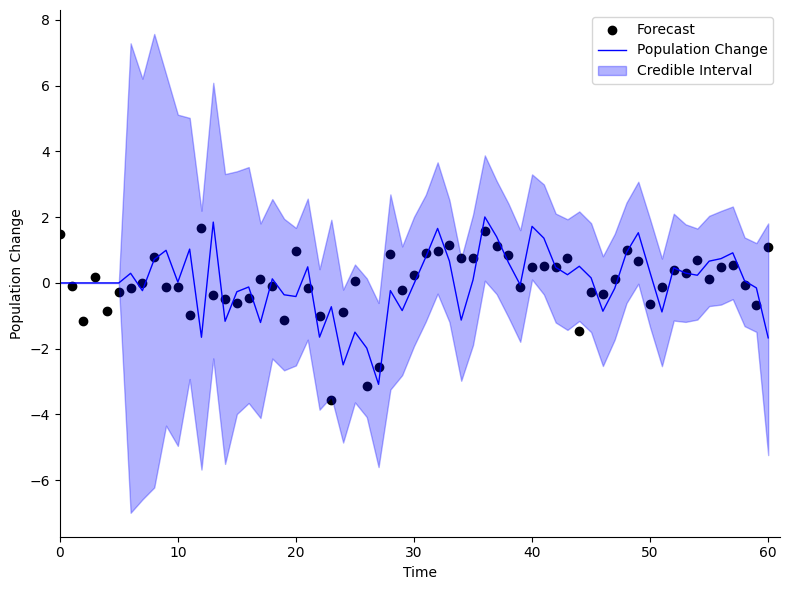

In [95]:
# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, mv_y, mv_for, mv_samp,
                        dates=np.arange(0, len(mv_y), dtype='int'))
ax = ax_style(ax, ylabel='Population Change', xlabel='Time', xlim=[0, len(mv_y)],
              legend=['Forecast', 'Population Change', 'Credible Interval'])


In [89]:
#univariate
# Calculate Bayesian estimate for the univariate model
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(None, filtered_data['JailPop_Change'])

MAPE: 7.82
MSE: 0.64


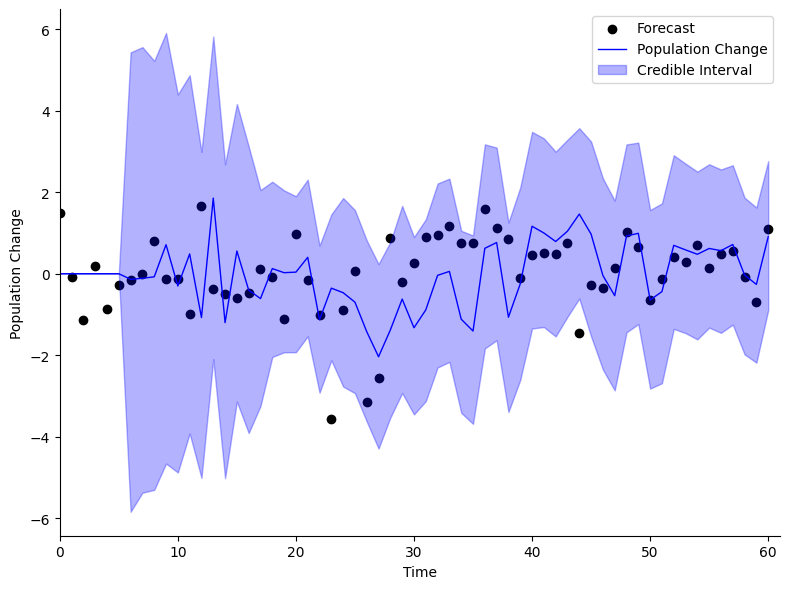

In [90]:
# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, uv_y, uv_for, uv_samp,
                        dates=np.arange(0, len(uv_y), dtype='int'))
ax = ax_style(ax, ylabel='Population Change', xlabel='Time', xlim=[0, len(uv_y)],
              legend=['Forecast', 'Population Change', 'Credible Interval'])

In [9]:
#lets try and optimize these models
import pybats as pb
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the train-test split index
train_idx = 55

# Split the data into train and test sets
train_data = filtered_data[:train_idx]
test_data = filtered_data[train_idx:]

# Define the parameter values to search over
seasHarmComponents_values = [[[1, 2, 3]], [[1, 2, 3, 4]], [[1, 2, 3, 4, 5]], [[1, 2, 3, 4, 5, 6]]]
prior_length_values = [1, 2, 3, 4, 5, 6]

# Initialize variables to store best parameters and MSE
best_params = None
best_mse = float('inf')

# Perform grid search
for harm_components in seasHarmComponents_values:
    for prior_length_val in prior_length_values:
        # Create and fit the model
        model = pb.GLM(
            train_data['JailPop_Change'],
            exog=train_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']],
            family='normal',
            ntrend=2,
            nsamps=5000,
            seasPeriods=[12],
            seasHarmComponents=harm_components,
            prior_length=prior_length_val,
            deltrend=0.94,
            delregn=0.90,
            delVar=0.98,
            delSeas=0.98,
            rho=0.3
        )
        model.fit()

        # Forecast on the test set
        forecasted_values = model.forecast(steps=len(test_data))
        predicted_values = forecasted_values['mean']

        # Calculate MSE
        mse = mean_squared_error(test_data['JailPop_Change'], predicted_values)

        # Check if this set of parameters resulted in lower MSE
        if mse < best_mse:
            best_mse = mse
            best_params = {'seasHarmComponents': harm_components, 'prior_length': prior_length_val}

# Print the best parameters and MSE
print("Best Parameters:")
print(best_params)
print("Best MSE: %.4f" % best_mse)


AttributeError: module 'pybats' has no attribute 'GLM'

In [10]:
import pybats as pb
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the train-test split index
train_idx = 55

# Split the data into train and test sets
train_data = filtered_data[:train_idx]
test_data = filtered_data[train_idx:]

# Define the parameter values to search over
seasHarmComponents_values = [[[1, 2, 3]], [[1, 2, 3, 4]], [[1, 2, 3, 4, 5]], [[1, 2, 3, 4, 5, 6]]]
prior_length_values = [1, 2, 3, 4, 5, 6]

# Initialize variables to store best parameters and MSE
best_params = None
best_mse = float('inf')

# Perform grid search
for harm_components in seasHarmComponents_values:
    for prior_length_val in prior_length_values:
        # Create and fit the model
        model = pb.GLM(
            train_data['JailPop_Change'],
            X=pb.design_matrix(train_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']], seasPeriods=[12]),
            family=pb.families.Normal(),
            prior_length=prior_length_val,
            ntrend=2,
            seasPeriods=[12],
            seasHarmComponents=harm_components,
            rho=0.3
        )
        model.fit()

        # Forecast on the test set
        forecasted_values = model.predict(test_data.shape[0])
        predicted_values = forecasted_values.y

        # Calculate MSE
        mse = mean_squared_error(test_data['JailPop_Change'], predicted_values)

        # Check if this set of parameters resulted in lower MSE
        if mse < best_mse:
            best_mse = mse
            best_params = {'seasHarmComponents': harm_components, 'prior_length': prior_length_val}

# Print the best parameters and MSE
print("Best Parameters:")
print(best_params)
print("Best MSE: %.4f" % best_mse)


AttributeError: module 'pybats' has no attribute 'GLM'

In [12]:
from sklearn.metrics import mean_squared_error

# Define the train-test split index
train_idx = 55

# Split the data into train and test sets
train_data = filtered_data[:train_idx]
test_data = filtered_data[train_idx:]

# Define the parameter values to search over
seasHarmComponents_values = [[[1, 2, 3]], [[1, 2, 3, 4]], [[1, 2, 3, 4, 5]], [[1, 2, 3, 4, 5, 6]]]
prior_length_values = [1, 2, 3, 4, 5, 6]

# Initialize variables to store best parameters and MSE
best_params = None
best_mse = float('inf')

# Perform grid search
for harm_components in seasHarmComponents_values:
    for prior_length_val in prior_length_values:
        # Create and fit the model
        model = define_dglm(
            train_data['JailPop_Change'].values,
            X=train_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']].values,
            family='normal',
            k=2,
            prior_length=prior_length_val,
            seasPeriods=[12],
            seasHarmComponents=harm_components,
            deltrend=0.94,
            delregn=0.90,
            delVar=0.98,
            delSeas=0.98,
            rho=0.3,
        )
        model.fit()

        # Forecast on the test set
        forecasted_values = model.predict(nsteps=15, X=train_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']].values)
        predicted_values = forecasted_values.y

        # Calculate MSE
        mse = mean_squared_error(test_data['JailPop_Change'], predicted_values)

        # Check if this set of parameters resulted in lower MSE
        if mse < best_mse:
            best_mse = mse
            best_params = {'seasHarmComponents': harm_components, 'prior_length': prior_length_val}

# Print the best parameters and MSE
print("Best Parameters:")
print(best_params)
print("Best MSE: %.4f" % best_mse)


C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1529: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybats\dglm.py:336: RuntimeWarning: invalid value encountered in subtract
  return self.R / Discount - self.R


AttributeError: 'dlm' object has no attribute 'fit'

In [14]:
import pybats.shared as shared
from pybats.define_models import define_dglm
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the train-test split index
train_idx = 55

# Split the data into train and test sets
train_data = filtered_data[:train_idx]
test_data = filtered_data[train_idx:]

# Define the parameter values to search over
seasHarmComponents_values = [[[1, 2, 3]], [[1, 2, 3, 4]], [[1, 2, 3, 4, 5]], [[1, 2, 3, 4, 5, 6]]]
prior_length_values = [1, 2, 3, 4, 5, 6]

# Initialize variables to store best parameters and MSE
best_params = None
best_mse = float('inf')

# Perform grid search
for harm_components in seasHarmComponents_values:
    for prior_length_val in prior_length_values:
        # Create and fit the model
        model = define_dglm(
            train_data['JailPop_Change'].values,
            X=train_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']].values,
            family='normal',
            k=2,
            prior_length=prior_length_val,
            seasPeriods=[12],
            seasHarmComponents=harm_components,
            deltrend=0.94,
            delregn=0.90,
            delVar=0.98,
            delSeas=0.98,
            rho=0.3,
        )
        
        model, samples = shared.fit_with_gibbs(model, nsamps=5000)

        # Forecast on the test set
        forecasted_values = model.predict(nsteps=15, X=test_data[['BailNotPosted_ArrRel', 'Total_Arraignments_lag1']].values)
        predicted_values = forecasted_values.y

        # Calculate MSE
        mse = mean_squared_error(test_data['JailPop_Change'], predicted_values)

        # Check if this set of parameters resulted in lower MSE
        if mse < best_mse:
            best_mse = mse
            best_params = {'seasHarmComponents': harm_components, 'prior_length': prior_length_val}

# Print the best parameters and MSE
print("Best Parameters:")
print(best_params)
print("Best MSE: %.4f" % best_mse)


C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1529: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybats\dglm.py:336: RuntimeWarning: invalid value encountered in subtract
  return self.R / Discount - self.R


AttributeError: module 'pybats.shared' has no attribute 'fit_with_gibbs'